In [1]:
import pandas as pd

df = pd.read_csv("Data Cleaning Exercise.csv")

In [2]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d-%m-%Y %H:%M')
df.set_index('DateTime', inplace=True)

full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(full_range)

missing_values = df.isnull().sum()

summary = {
    'missing_values': missing_values,
    'first_entries': df.head(),
    'data_types': df.dtypes
}

summary


{'missing_values': TotalLoadValue    40
 dtype: int64,
 'first_entries':                      TotalLoadValue
 2014-12-19 09:00:00         34456.0
 2014-12-19 10:00:00         33975.0
 2014-12-19 11:00:00         33454.0
 2014-12-19 12:00:00         32967.0
 2014-12-19 13:00:00         31753.0,
 'data_types': TotalLoadValue    float64
 dtype: object}

In [3]:
df_interpolated = df.interpolate(method='linear')

missing_values_after_interpolation = df_interpolated.isnull().sum()

q1 = df_interpolated['TotalLoadValue'].quantile(0.25)
q3 = df_interpolated['TotalLoadValue'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = df_interpolated[(df_interpolated['TotalLoadValue'] < lower_bound) | 
                           (df_interpolated['TotalLoadValue'] > upper_bound)]

outlier_count = len(outliers)

imputation_and_outlier_summary = {
    'missing_values_after_interpolation': missing_values_after_interpolation,
    'outlier_count': outlier_count,
    'outliers': outliers
}

imputation_and_outlier_summary


{'missing_values_after_interpolation': TotalLoadValue    0
 dtype: int64,
 'outlier_count': 0,
 'outliers': Empty DataFrame
 Columns: [TotalLoadValue]
 Index: []}

In [12]:
df_smoothed = df_interpolated.rolling(window=3, center=True).mean()

df_smoothed.dropna(inplace=True)

df_smoothed.head()

df_smoothed.to_csv("df_smoothed.csv")


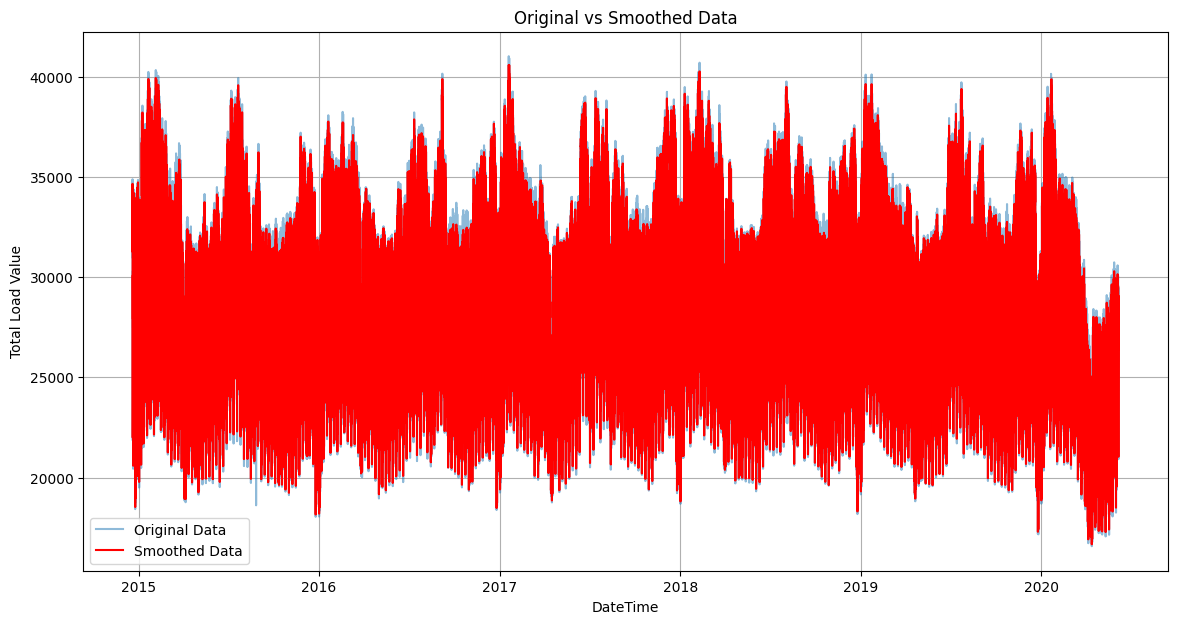

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_interpolated.index, df_interpolated['TotalLoadValue'], label='Original Data', alpha=0.5)

plt.plot(df_smoothed.index, df_smoothed['TotalLoadValue'], label='Smoothed Data', color='red')

plt.title('Original vs Smoothed Data')
plt.xlabel('DateTime')
plt.ylabel('Total Load Value')
plt.legend()
plt.grid(True)

plt.show()


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df_minmax_scaled = minmax_scaler.fit_transform(df_smoothed)

df_standard_scaled = standard_scaler.fit_transform(df_smoothed)

df_minmax_scaled = pd.DataFrame(df_minmax_scaled, index=df_smoothed.index, columns=df_smoothed.columns)
df_standard_scaled = pd.DataFrame(df_standard_scaled, index=df_smoothed.index, columns=df_smoothed.columns)

scaled_dataframes_head = {
    'minmax_scaled_head': df_minmax_scaled.head(),
    'standard_scaled_head': df_standard_scaled.head()
}

scaled_dataframes_head


{'minmax_scaled_head':                      TotalLoadValue
 2014-12-19 10:00:00        0.723197
 2014-12-19 11:00:00        0.702436
 2014-12-19 12:00:00        0.671454
 2014-12-19 13:00:00        0.638339
 2014-12-19 14:00:00        0.610382,
 'standard_scaled_head':                      TotalLoadValue
 2014-12-19 10:00:00        1.215001
 2014-12-19 11:00:00        1.105038
 2014-12-19 12:00:00        0.940943
 2014-12-19 13:00:00        0.765550
 2014-12-19 14:00:00        0.617481}

In [7]:
df_binned = df_smoothed.copy()
df_binned['Load_Quartile'] = pd.qcut(df_smoothed['TotalLoadValue'], q=4, labels=False)

correlation_matrix = df_binned.corr()

binned_data_and_correlation = {
    'binned_data_head': df_binned.head(),
    'correlation_matrix': correlation_matrix
}

binned_data_and_correlation


{'binned_data_head':                      TotalLoadValue  Load_Quartile
 2014-12-19 10:00:00    33961.666667              3
 2014-12-19 11:00:00    33465.333333              3
 2014-12-19 12:00:00    32724.666667              3
 2014-12-19 13:00:00    31933.000000              3
 2014-12-19 14:00:00    31264.666667              2,
 'correlation_matrix':                 TotalLoadValue  Load_Quartile
 TotalLoadValue        1.000000       0.953744
 Load_Quartile         0.953744       1.000000}

c:\Users\wyero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


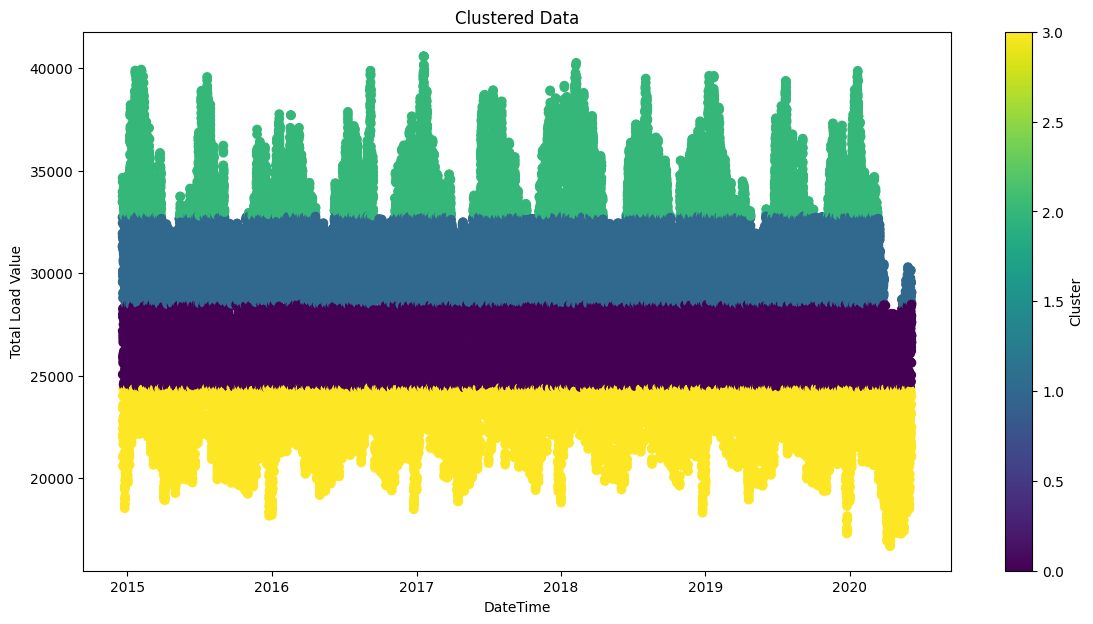

{'cluster_centers': array([[-0.48204017],
        [ 0.47733446],
        [ 1.4278008 ],
        [-1.32304691]]),
 'cluster_counts': 1    14916
 0    13040
 3    10688
 2     9242
 Name: Cluster, dtype: int64}

In [8]:
from sklearn.cluster import KMeans

# 4 is chosen Randomly
kmeans = KMeans(n_clusters=4, random_state=0)

df_standard_scaled['Cluster'] = kmeans.fit_predict(df_standard_scaled)

cluster_centers = kmeans.cluster_centers_
cluster_counts = df_standard_scaled['Cluster'].value_counts()

df_smoothed['Cluster'] = df_standard_scaled['Cluster']

plt.figure(figsize=(14, 7))
plt.scatter(df_smoothed.index, df_smoothed['TotalLoadValue'], c=df_smoothed['Cluster'], cmap='viridis')

plt.title('Clustered Data')
plt.xlabel('DateTime')
plt.ylabel('Total Load Value')
plt.colorbar(label='Cluster')

plt.show()

{
    'cluster_centers': cluster_centers,
    'cluster_counts': cluster_counts
}


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_trend = df_smoothed.rolling(window=24, center=True).mean()

decomposition = seasonal_decompose(df_smoothed['TotalLoadValue'], model='additive', period=24)

trend_component = decomposition.trend.dropna()
seasonal_component = decomposition.seasonal.dropna()
residual_component = decomposition.resid.dropna()

residual_z_scores = (residual_component - residual_component.mean()) / residual_component.std()
anomalies = residual_z_scores[(residual_z_scores > 3) | (residual_z_scores < -3)]

trend_seasonality_anomaly = {
    'trend': trend_component.head(),
    'seasonality': seasonal_component.head(),
    'anomalies': anomalies
}

trend_seasonality_anomaly


{'trend': 2014-12-19 22:00:00    28968.125000
 2014-12-19 23:00:00    28813.881944
 2014-12-20 00:00:00    28674.444444
 2014-12-20 01:00:00    28547.909722
 2014-12-20 02:00:00    28424.680556
 Freq: H, Name: trend, dtype: float64,
 'seasonality': 2014-12-19 10:00:00    3396.800490
 2014-12-19 11:00:00    3393.058043
 2014-12-19 12:00:00    2989.730352
 2014-12-19 13:00:00    2383.159594
 2014-12-19 14:00:00    1818.927213
 Freq: H, Name: seasonal, dtype: float64,
 'anomalies': 2014-12-21 07:00:00   -3.011989
 2014-12-25 07:00:00   -3.180740
 2014-12-25 08:00:00   -3.268838
 2014-12-28 07:00:00   -3.386057
 2014-12-28 08:00:00   -3.200125
                          ...   
 2020-01-01 09:00:00   -3.314438
 2020-01-19 07:00:00   -3.274129
 2020-01-21 03:00:00   -3.088569
 2020-03-22 07:00:00   -3.308884
 2020-03-22 08:00:00   -3.106680
 Name: resid, Length: 91, dtype: float64}

ADF Statistic: -16.381504
p-value: 0.000000


c:\Users\wyero\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


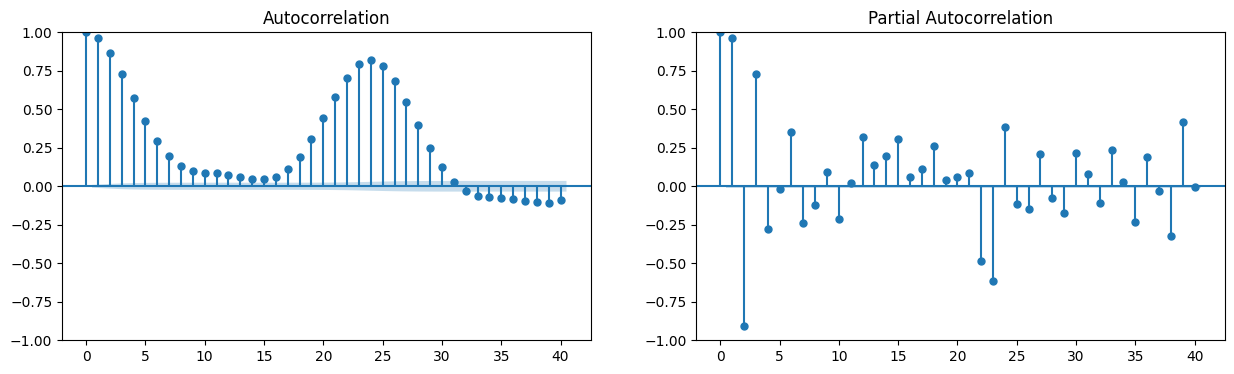

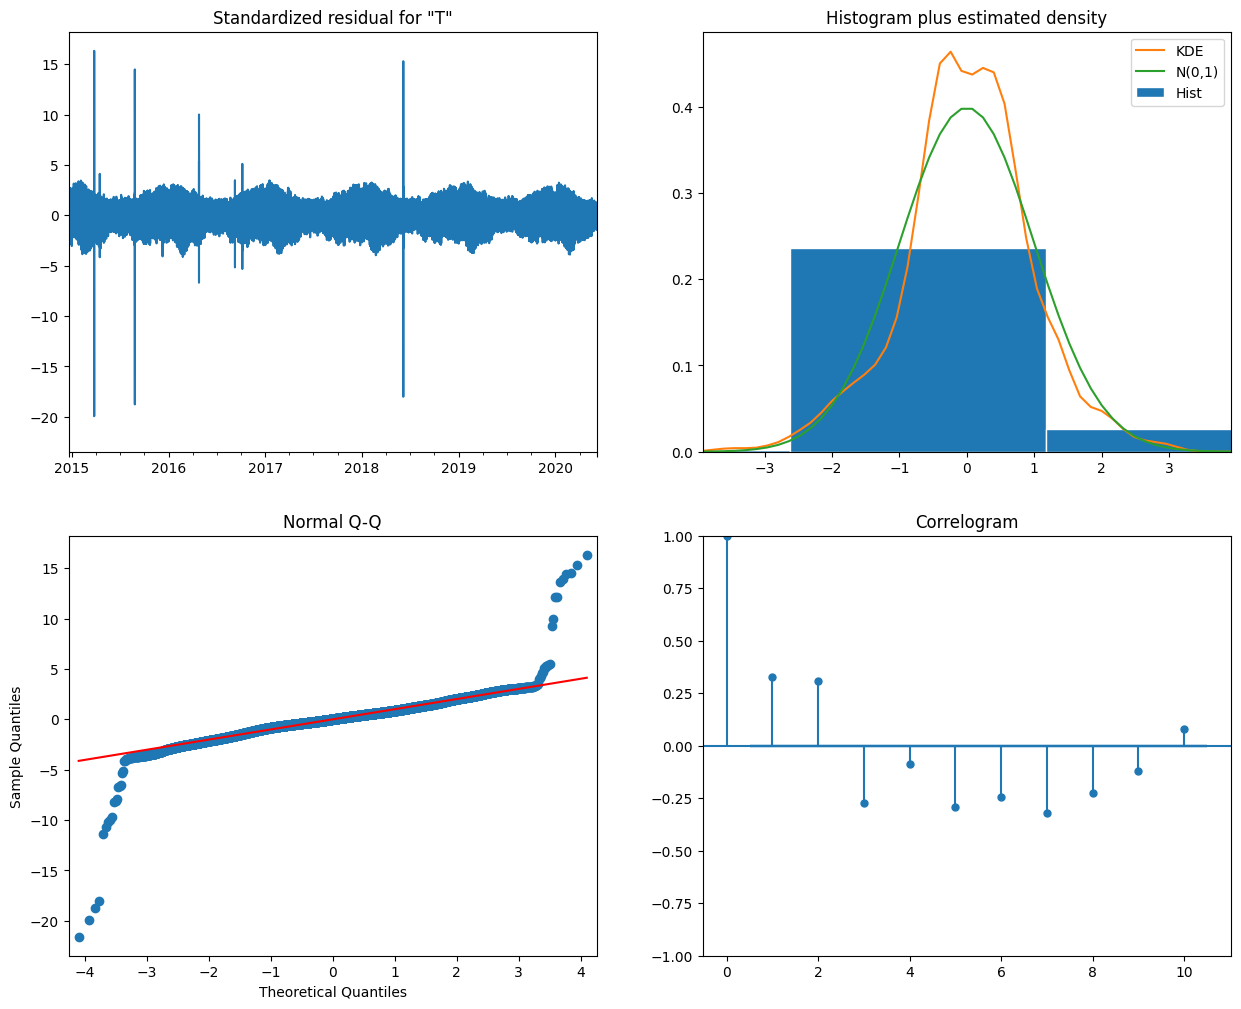

ValueError: too many values to unpack (expected 3)

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(df_smoothed['TotalLoadValue'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# If the p-value is above a critical size (0.05), then we cannot reject the null hypothesis of the presence of a unit root.

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_smoothed['TotalLoadValue'].dropna(), lags=40, ax=axes[0])
plot_pacf(df_smoothed['TotalLoadValue'].dropna(), lags=40, ax=axes[1])
plt.show()

model = sm.tsa.ARIMA(df_smoothed['TotalLoadValue'].dropna(), order=(1, 1, 1))
results = model.fit()

results.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast, stderr, conf_int = results.forecast(steps=24)  
plt.figure(figsize=(14, 7))
plt.plot(df_smoothed.index, df_smoothed['TotalLoadValue'], label='Observed')
plt.plot(pd.date_range(df_smoothed.index[-1], periods=24, freq='H'), forecast, label='Forecast')
plt.fill_between(pd.date_range(df_smoothed.index[-1], periods=24, freq='H'), conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()
